<a href="https://colab.research.google.com/github/ayotomiwaa/aml-numerai-2/blob/ezekiel-branch/Ezekiel_ED_Numerai_EDA_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle lazypredict pandas-profiling

# Inline plots
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.6/381.6 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires

## 1. Dataset  

At a high level, the Numerai dataset is a tabular dataset that describes the stock market over time.

Each row represents a stock at a specific point in time, where `id` is the stock id and the `era` is the date. The `features` describe the attributes of the stock (eg. P/E ratio) known on the date and the `target` is a measure of 20-day returns.

The unique thing about Numerai's dataset is that it is `obfuscated`, which means that the underlying stock ids, feature names, and target definitions are anonymized. This makes it so that we can give this data out for free and so that it can be modeled without any financial domain knowledge (or bias!).

### Downloading the Dataset

In [2]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()

# Print all files available for download in the latest dataset
[f for f in napi.list_datasets() if f.startswith("v4.2")]

['v4.2/features.json',
 'v4.2/live_benchmark_models.parquet',
 'v4.2/live_example_preds.csv',
 'v4.2/live_example_preds.parquet',
 'v4.2/live_int8.parquet',
 'v4.2/meta_model.parquet',
 'v4.2/train_benchmark_models.parquet',
 'v4.2/train_int8.parquet',
 'v4.2/validation_benchmark_models.parquet',
 'v4.2/validation_example_preds.csv',
 'v4.2/validation_example_preds.parquet',
 'v4.2/validation_int8.parquet']

In [3]:
import pandas as pd
import json

# # Download the training data and feature metadata
# # This will take a few minutes 🍵
napi.download_dataset("v4.2/train_int8.parquet");
napi.download_dataset("v4.2/features.json");

v4.2/train_int8.parquet: 1.88GB [01:37, 19.4MB/s]                            
v4.2/features.json: 1.03MB [00:00, 12.0MB/s]                   


In [4]:
# Load only the "medium" feature set to reduce memory usage and speedup model training (required for Colab free tier)
# Use the "all" feature set to use all features
feature_metadata = json.load(open("v4.2/features.json"))
feature_cols = feature_metadata["feature_sets"]["medium"]
train = pd.read_parquet("v4.2/train_int8.parquet", columns=["era"] + feature_cols + ["target"])

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data
train = train[train["era"].isin(train["era"].unique()[::200])]
train

,era,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_additive_untrustworthy_hierologist,feature_adsorbed_blizzardy_burlesque,feature_affettuoso_taxidermic_greg,...,feature_wistful_tussive_cycloserine,feature_witchy_orange_muley,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,target
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,0,4,0,4,2,0,1,4,0,...,4,0,0,2,4,2,4,2,2,0.25
n003bee128c2fcfc,0001,4,2,2,2,2,3,1,3,2,...,3,3,3,2,0,2,2,3,2,0.75
n0048ac83aff7194,0001,4,4,2,0,2,0,4,1,3,...,0,0,1,2,0,2,3,1,2,0.25
n00691bec80d3e02,0001,1,4,1,1,2,0,2,1,2,...,0,2,1,2,2,2,3,2,2,0.75
n00b8720a2fdc4f2,0001,0,2,0,0,2,0,3,1,0,...,3,1,1,2,0,2,0,1,2,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffeaee03110f441,0401,3,2,4,0,4,3,3,4,2,...,4,4,2,2,3,0,3,4,1,0.50
nffefe5f3e97da10,0401,4,1,2,1,1,0,0,2,2,...,1,2,3,0,4,0,3,3,0,0.50
nfff32db8b586b25,0401,1,4,3,4,3,2,1,4,3,...,4,4,1,3,3,1,2,4,0,0.50


### Eras
As mentioned above, each `era` corresponds to a different date. Each era is exactly 1 week apart.

It is helpful to think about rows of stocks within the same `era` as a single example. You will notice that throughout this notebook and other examples, we often talk about things "per era". For example, the number of rows per era represents the number of stocks in Numerai's investable universe on that date.

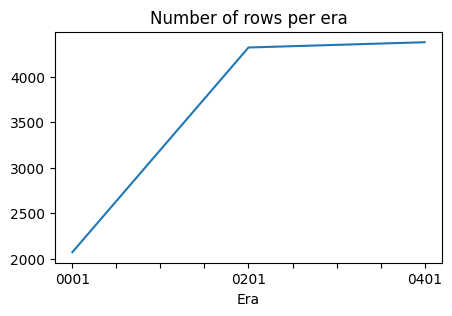

In [5]:
# Plot the number of rows per era
train.groupby("era").size().plot(title="Number of rows per era", figsize=(5, 3), xlabel="Era");

### Features
As mentioned above, `features` are quantitative attributes of each stock: fundamentals like P/E ratio, technical signals like RSI, market data like short interest, secondary data like analyst ratings, and much more.

The underlying definition of each feature is not important, just know that Numerai has included these features in the dataset because we believe they are predictive of the `target`.

In [6]:
train.shape

(10770, 585)

Feature values are binned into 5 equal bins: `0`, `1`, `2`, `3`, `4`. This heavy regularization of feature values is to avoid overfitting as the underlying values are extremely noisy.

If data for a particular feature is missing for that era (more common in early `eras`), then all values will be set to `2`.

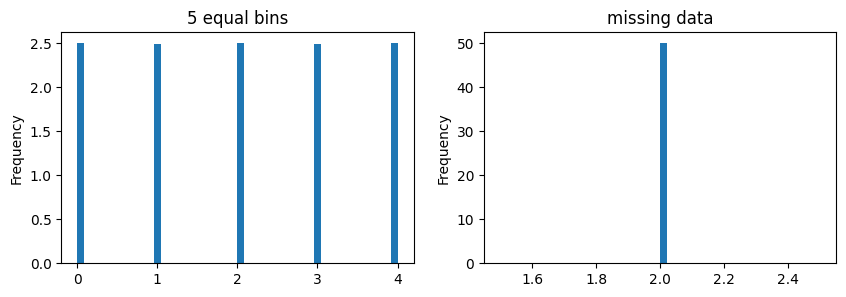

In [7]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
first_era = train[train["era"] == train["era"].unique()[0]]
last_era = train[train["era"] == train["era"].unique()[-1]]
last_era[feature_cols[-1]].plot(kind="hist", title="5 equal bins", density=True, bins=50, ax=ax1);
first_era[feature_cols[-1]].plot(kind="hist", title="missing data", density=True, bins=50, ax=ax2);

### Target
The `target` is a measure of 20-day stock market returns. Specifically, it is a measure of "stock-specific" returns that are not "explained" by broader trends in the market, country, sector, or well-known "factors".

Target values are binned into 5 unequal bins: `0`, `0.25`, `0.5`, `0.75`, `1.0`. Again, this heavy regularization of target values is to avoid overfitting as the underlying values are extremely noisy.

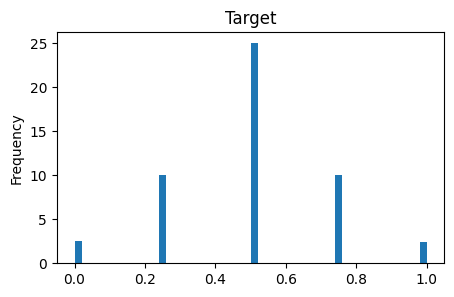

In [8]:
# Plot density histogram of the target
train["target"].plot(kind="hist", title="Target", figsize=(5, 3), xlabel="Value", density=True, bins=50);

### Pandas Profiling Report

In [9]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(train, title="Profiling Report", minimal=True,)

In [10]:
# profile.to_notebook_iframe()

In [11]:
# profile.to_file("pandas_profile.html")

### Reduce Dataset

In [12]:
# divisor = 10

# train = train.tail(int(train.shape[0]/50))

# import random

# # Calculate the number of features to select (a quarter of the total)
# num_features_to_select = len(feature_cols) // (100)  # Use // for integer division

# # Randomly select a quarter of features
# selected_features = random.sample(feature_cols, num_features_to_select)

### Baseline Modelling (AutoML)

In [13]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np

# Define the features and target
X = train[feature_cols]
y = train['target']

# Split the data into training and testing sets stratified by multiple columns
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=train[['era', 'target']]
)

In [14]:
print(X_test.shape)
print(X_train.shape)

(2154, 583)
(8616, 583)


In [16]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

 24%|██▍       | 10/42 [03:09<16:06, 30.22s/it]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 76%|███████▌  | 32/42 [25:02<01:53, 11.38s/it]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


 98%|█████████▊| 41/42 [28:05<00:08,  8.12s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3495
[LightGBM] [Info] Number of data points in the train set: 8616, number of used features: 583
[LightGBM] [Info] Start training from score 0.499623


100%|██████████| 42/42 [28:08<00:00, 40.20s/it]


In [17]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
PoissonRegressor,-0.37,0.00,0.22,0.41
LassoCV,-0.37,0.00,0.22,46.40
ElasticNetCV,-0.37,0.00,0.22,48.47
LassoLarsCV,-0.37,0.00,0.22,6.86
LassoLarsIC,-0.37,0.00,0.22,1.83
LarsCV,-0.37,0.00,0.22,4.00
TweedieRegressor,-0.37,0.00,0.22,0.49
BayesianRidge,-0.37,0.00,0.22,1.54
DummyRegressor,-0.37,0.00,0.22,0.21
